# ARGAN Open Source Example

- Pavia example of argan method

In [ ]:
!pip install -U scikit-learn==0.21.3
!pip install -U spectral

     |████████████████████████████████| 6.7MB 7.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 215kB 6.9MB/s 


# Data

download pavia if necessary

In [1]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2020-11-17 08:20:00--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Résolution de www.ehu.eus (www.ehu.eus)… 158.227.0.65, 2001:720:1410::65
Connexion à www.ehu.eus (www.ehu.eus)|158.227.0.65|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 34806917 (33M)
Enregistre : «PaviaU.mat.1»

PaviaU.mat.1        100%[===================>]  33,19M  1,17MB/s    ds 24s     

2020-11-17 08:20:25 (1,37 MB/s) - «PaviaU.mat.1» enregistré [34806917/34806917]

--2020-11-17 08:20:25--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Résolution de www.ehu.eus (www.ehu.eus)… 158.227.0.65, 2001:720:1410::65
Connexion à www.ehu.eus (www.ehu.eus)|158.227.0.65|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 11005 (11K)
Enregistre : «PaviaU_gt.mat.1»

PaviaU_gt.mat.1     100%[===================>]  10,75K  --.-KB/s    ds 0s      

2020-11-17 08:20:25 (137 MB/s) - «PaviaU_gt.mat.1» enregistré [11005/11005]



methods to read data

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

def read_HSI():
    X = loadmat('PaviaU.mat')['paviaU']
    y = loadmat('PaviaU_gt.mat')['paviaU_gt']
    print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X, y

def band_norm(img_, eps=1e-8):
    "normalize to [0-1]"
    img = np.asarray(img_, dtype='float32')
    for i in range(np.shape(img)[-1]):
        img[:,:,i] = (img[:,:,i] - np.min(img[:,:,i])) / (np.max(img[:,:,i]) - np.min(img[:,:,i]))
    return img

pavia, gt = read_HSI()

pavia = band_norm(pavia)

X shape: (610, 340, 103)
y shape: (610, 340)


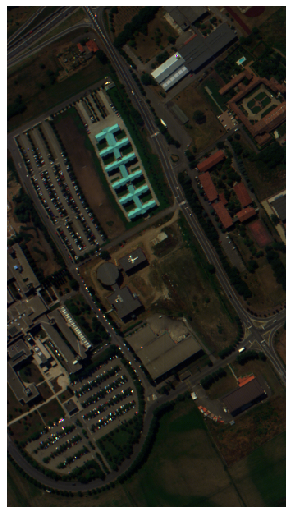

In [2]:
nbands=[58,30,5]

plt.figure(figsize=(5,10))
plt.imshow(pavia[:,:,nbands])
plt.axis('off')
plt.show()

methods to make train/test sets

In [3]:
from AdvGAN_2 import utils

train, test = utils.sample_gt(gt, 0.66)
X_train, y_train = utils.make_set(pavia, train)
X_test, y_test = utils.make_set(pavia, test)

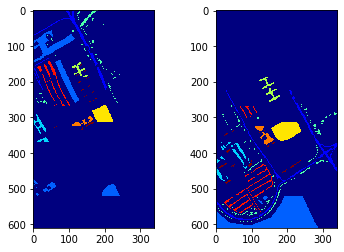

In [4]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(train, cmap='jet', interpolation='nearest')
axarr[1].imshow(test, cmap='jet', interpolation='nearest')
plt.show()

# SVM

In [5]:
import scipy as sp
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

In [6]:
retrain = False

Either retrain SVM or load it from save

In [7]:
if retrain:
  param_grid_svm = dict(gamma=2.0**sp.arange(-8,0), C=2.0**sp.arange(0,8))
  cv = StratifiedKFold(n_splits=5,random_state=0).split(X_train,y_train)
  grid = GridSearchCV(svm.SVC(), param_grid=param_grid_svm, cv=cv,n_jobs=-1)
  grid.fit(X_train, y_train)

  clf_svm = grid.best_estimator_
  clf_svm.set_params(probability=True)
  clf_svm.fit(X_train,y_train)
else:
  from joblib import load
  clf_svm = load('data/clf_svm.joblib') 

In [8]:
yp = clf_svm.predict(X_test)

In [9]:
cm = confusion_matrix(y_test, yp)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm.diagonal()

array([0.85755534, 0.83682224, 0.23381569, 0.96977592, 0.99761337,
       0.86568123, 0.93195626, 0.84538328, 1.        ])

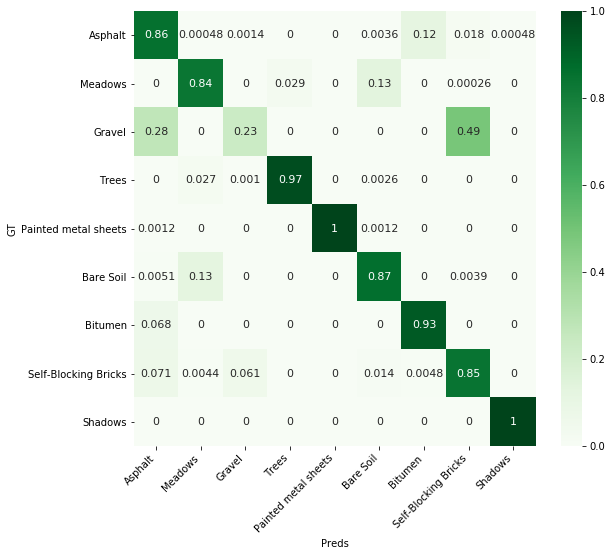

In [10]:
import seaborn as sns 

classes = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows"] 	
plt.figure(figsize=(9,8))
ax = sns.heatmap(cm_norm,annot=True,annot_kws={"size": 11},cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.ylabel('GT')
plt.xlabel('Preds')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

# ARGAN

In [11]:
class Classifier:
    
    def  __init__(self, model):
        self.model = model 
        
    def load_model(self):
        pass
        
    def load_weights(self):
        pass

    def predict(self, X):
        X = np.reshape(X, (-1, 103))
        X = (X+1)/2
        return self.model.predict_proba(X)
    
classifier = Classifier(clf_svm)

Visualization methods

In [12]:
def plot_mean_std(samples, color='blue'):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    std_minus = plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std', color=color)
    mean = plt.plot(mean_spectrum, label='mean', color=color)
    std_plus = plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std', color=color)
    fill = plt.fill_between(range(len(mean_spectrum)), mean_spectrum + std_spectrum, mean_spectrum - std_spectrum, facecolor=color, alpha=0.2)
    return std_minus, mean, std_plus, fill

def extract_one_label(x_arr, y_arr, lbl):
    mask =  np.array([1 if x==lbl else 0 for x in y_arr])
    x = x_arr*np.expand_dims(mask, -1)
    y = y_arr*mask
    x = x[y!=0]
    y = y[y!=0]
    return x, y

bound data between -1 and 1

In [13]:
x_all = pavia.reshape((-1, 103))*2-1
y_all = gt.flatten()

extract asphalt and meadows

In [14]:
X_meadows, y_meadows = extract_one_label(x_all, y_all, 2)
X_asphalt, y_asphalt = extract_one_label(x_all, y_all, 1)

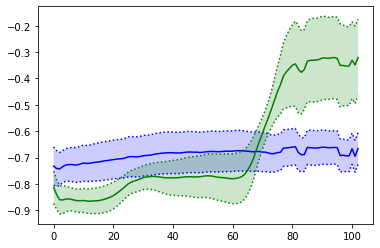

In [15]:
_, a, _, _ = plot_mean_std(np.reshape(X_asphalt, (-1,103)), 'blue')
_, a, _, _ = plot_mean_std(np.reshape(X_meadows, (-1,103)), 'green')

# Model

In [16]:
from AdvGAN_2 import dataset, models, utils, gan, print_functions

AdvGAN library


In [17]:
generator = models.GeneratorConv1D(img_size=103, hiddens_dims=[64,32,16], output="tanh")
discriminator = models.DiscriminatorConv1D(hiddens_dims=[16,32,64], output=None)

Here we want to generate adversarial spectra for Meadows

In [18]:
x_meadows = np.reshape(X_meadows[:, :103], (-1, 103, 1))

In [19]:
# G_OPTIMIZER
g_optim = {'name': 'RMSProp', 'learning_rate': 5e-5}

# D_OPTIMIZER
d_optim = {'name': 'RMSProp', 'learning_rate': 1e-4}

data = dataset.DatasetBuilder(x_meadows, np.eye(9)[y_meadows-1], batch_size=64)

# Build option for CFG (options not set in cfg are set with default values)
advgan = gan.make_gan('cfg/pavia.cfg')

advgan.set_generator(generator)

advgan.set_discriminator(discriminator)

advgan.set_classifier(classifier)

advgan.set_dataset(data)
advgan.set_batch_size(64)

Number of data :  18649


None

samples :


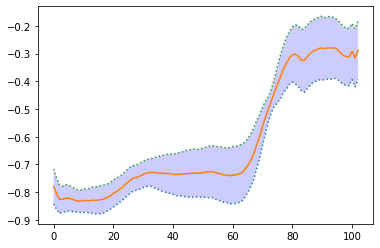

neg loss :


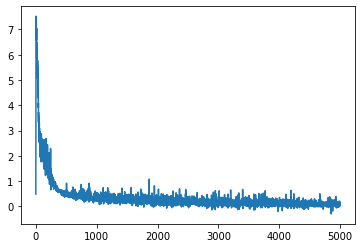

loss critic :


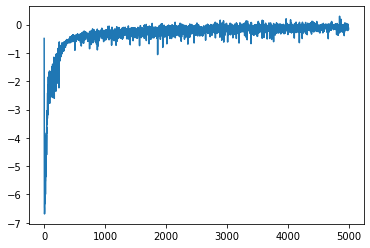

loss generator :


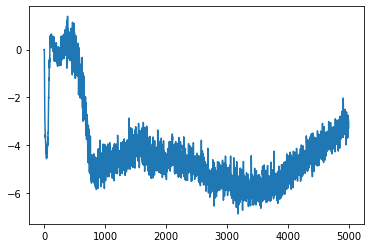

5000 d loss: -0.15635620057582855 g loss: -3.015218496322632


<Figure size 432x288 with 0 Axes>

In [20]:
advgan.train(print_method=print_functions.plot_samples_mean_std(103))

In [ ]:
advs = []

while len(advs) < 1000:
    gens = advgan.generate()
    yp = classifier.predict(gens)
    yp = np.argmax(yp, 1)
    for g, y_ in zip(gens, yp):
        if y_ != 1:
            advs.append(g)

In [ ]:
yp = classifier.predict(advs)
yp = np.argmax(yp, 1)

# Generate adversarial spectra

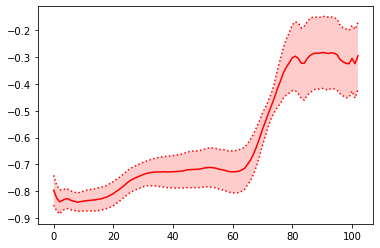

In [ ]:
_, a, _, _ = plot_mean_std(np.reshape(advs, (-1,103)), 'red')

We replace original meadows by adv meadows -> We choose the closest spectra

In [ ]:
from sklearn.neighbors import NearestNeighbors

img_adv = np.copy(pavia)

adv_g = np.reshape(advs, (-1, 103))
print(np.shape(adv_g))
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(adv_g)

for i in range(610):
    for j in range(340):
        if(gt[i,j] == 2):
            d, idx = nn.kneighbors([pavia[i,j]*2-1])
            img_adv[i, j] = adv_g[int(idx[0])] 


(1013, 103)


In [ ]:
x_all_adv = img_adv.reshape((-1, 103))

In [ ]:
X_meadows_adv, _ = extract_one_label(x_all_adv, y_all, 2)

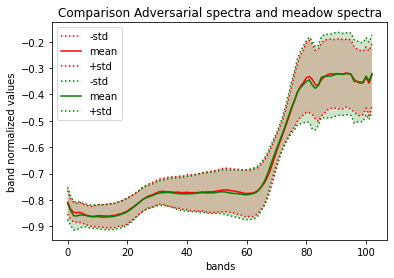

In [ ]:
_, a, _, _ = plot_mean_std(np.reshape(X_meadows_adv, (-1,103)), 'red')
_, a, _, _ = plot_mean_std(np.reshape(X_meadows, (-1,103)), 'green')
plt.title('Comparison Adversarial spectra and meadow spectra')
plt.xlabel('bands')
plt.ylabel('band normalized values')
plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score

yp = np.argmax(classifier.predict(X_meadows), 1)
yp_adv = np.argmax(classifier.predict(X_meadows_adv), 1)

Original accuracy

In [ ]:
accuracy_score(yp, np.ones(len(yp)))

0.8897528017588074



Accuracy on adversarial spectra

In [ ]:
accuracy_score(yp_adv, np.ones(len(yp_adv)))

0.0

So our generated spectra is statistically close to the source spectra and is also fully misclassified. Then we can conclude it is an adversarial spectra.

In [ ]:
h, w, _ = np.shape(pavia)

y_pred = []
y_pred_adv = []

for i in range(h):
  line = classifier.predict(pavia[i]*2-1)
  y_pred.append(line)
  line_adv = classifier.predict(img_adv[i]*2-1)
  y_pred_adv.append(line_adv)

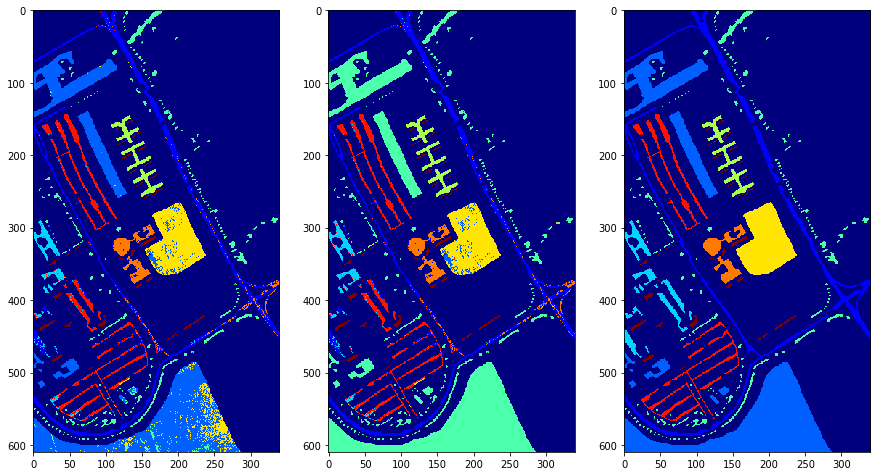

In [ ]:
y_show_1 = np.argmax(y_pred, 2)
y_show_1 = y_show_1+1

y_show_2 = np.argmax(y_pred_adv, 2)
y_show_2 = y_show_2+1

mask = gt > 0

f, axarr = plt.subplots(1, 3,figsize=(15,30))
axarr[0].imshow(y_show_1*mask, cmap='jet', interpolation='nearest')
axarr[1].imshow(y_show_2*mask, cmap='jet', interpolation='nearest')
axarr[2].imshow(gt, cmap='jet', interpolation='nearest')

Comparison with most predicted classes. 

We now want to see what classes are predicted for our adversarial spectra and compare there spectra.

In [ ]:
classes, counts = np.unique(yp_adv, return_counts=True)

classes_name = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows"]
for i, j in zip(classes, counts):
  print(classes_name[i], ":", j/len(yp_adv)*100, "%")

Asphalt : 0.005362217813287575 %
Trees : 16.30114215239423 %
Bare Soil : 83.69349562979248 %


In [ ]:
X_trees, _ = extract_one_label(x_all, y_all, 4)
X_bare_soil, _ = extract_one_label(x_all, y_all, 6)

In [ ]:
def plot_mean_std_compare(ax, samples, color='blue', compare=None):
    mean_spectrum = np.mean(samples, axis=0) - np.mean(compare, axis=0)
    std_spectrum = np.std(samples, axis=0) 
    std_minus = ax.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std', color=color)
    mean = ax.plot(mean_spectrum, label='mean', color=color)
    std_plus = ax.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std', color=color)
    fill = ax.fill_between(range(len(mean_spectrum)), mean_spectrum + std_spectrum, mean_spectrum - std_spectrum, facecolor=color, alpha=0.2)
    return std_minus, mean, std_plus, fill

In [ ]:
sub = np.reshape(X_meadows, (-1,103))

Text(0, 0.5, 'spectral mean - meadows speactra')

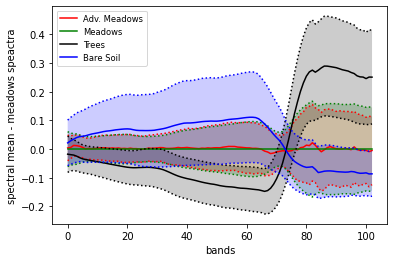

In [ ]:
fig, ax1 = plt.subplots()

_, a, _, _ = plot_mean_std_compare(ax1, np.reshape(X_meadows_adv, (-1,103)), 'red', sub)
_, b, _, _ = plot_mean_std_compare(ax1, np.reshape(X_meadows, (-1,103)), 'green', sub)
_, c, _, _ = plot_mean_std_compare(ax1, np.reshape(X_trees, (-1,103)), 'black', sub)
_, d, _, _ = plot_mean_std_compare(ax1, np.reshape(X_bare_soil, (-1,103)), 'blue', sub)

ax1.legend([a[0], b[0], c[0], d[0]], ['Adv. Meadows', 'Meadows', 'Trees', 'Bare Soil'], loc=0, fontsize='small');

plt.xlabel('bands')
plt.ylabel('spectral mean - meadows speactra')